In [1]:
import pandas as pd

df = pd.read_csv('../Dataset/FeatureEngineering_T2M_data.csv')
df.tail()

,date,tsoil1,tsoil2,tsoil3,tsoil4,t2m,t2m_max,t2m_min,t10m,t10m_max,...,t2m_volatility_3d_lag3,t2m_anomaly_lag1,t2m_anomaly_lag2,t2m_anomaly_lag3,temp_gradient_surface_lag1,temp_gradient_surface_lag2,temp_gradient_surface_lag3,wind_chill_factor_lag1,wind_chill_factor_lag2,wind_chill_factor_lag3
16360,2025-11-06,25.73,25.71,26.11,26.56,26.15,29.52,23.51,26.16,29.34,...,0.030380,-0.707586,-0.637586,-0.217586,-1.00,-0.82,-0.65,25.716,25.754,26.090
16361,2025-11-07,25.82,25.99,26.12,26.53,26.40,27.92,24.67,26.55,27.90,...,0.036043,-0.027586,-0.707586,-0.637586,-0.85,-1.00,-0.82,26.396,25.716,25.754
16362,2025-11-08,26.35,26.09,26.14,26.51,27.16,29.76,25.52,27.35,29.63,...,0.010329,0.222414,-0.027586,-0.707586,-0.26,-0.85,-1.00,26.639,26.396,25.716
16363,2025-11-09,27.01,26.53,26.25,26.50,27.78,30.85,25.51,28.00,30.76,...,0.014542,0.982414,0.222414,-0.027586,-0.18,-0.26,-0.85,27.039,26.639,26.396
16364,2025-11-10,27.22,26.89,26.45,26.50,27.96,30.47,26.15,28.21,30.25,...,0.018506,1.602414,0.982414,0.222414,-0.38,-0.18,-0.26,27.609,27.039,26.639


In [2]:
len(df.columns)

399

### X, y and Train / Test for Time Series

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
H = 7
t2m_targets = [f"t2m_d{h}_forecast" for h in range(1, H+1)]

In [5]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

feature_cols = [c for c in num_cols if c not in t2m_targets]

print("Number of features:", len(feature_cols))
print("Targets:", t2m_targets)

Number of features: 391
Targets: ['t2m_d1_forecast', 't2m_d2_forecast', 't2m_d3_forecast', 't2m_d4_forecast', 't2m_d5_forecast', 't2m_d6_forecast', 't2m_d7_forecast']


In [6]:
X = df[feature_cols]         # shape = (n_samples, n_features)
Y = df[t2m_targets]           # shape = (n_samples, 7)

In [7]:
test_ratio = 0.2
n_samples = len(df)
split_idx = int(n_samples * (1 - test_ratio))

# split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

print("Train size:", X_train.shape, Y_train.shape)
print("Test  size:", X_test.shape, Y_test.shape)

Train size: (13092, 391) (13092, 7)
Test  size: (3273, 391) (3273, 7)


### Train LightGBM (Multi-Output)

In [8]:
%pip install lightgbm optuna tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### feature importance

In [9]:
from lightgbm import LGBMRegressor

t2m_last_col = Y_train.columns[-1]

fs_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=63,
    random_state=42,
    n_jobs=-1
)

fs_model.fit(X_train, Y_train[t2m_last_col])

# ดึง feature importance
importances = pd.Series(fs_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# เลือก top-k features
TOP_K = 200  
selected_features = importances.head(TOP_K).index.tolist()

print(f"Selected top {TOP_K} features from LightGBM importance:")
print(selected_features)

X_train_fs = X_train[selected_features].copy()
X_test_fs  = X_test[selected_features].copy()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87208
[LightGBM] [Info] Number of data points in the train set: 13092, number of used features: 391
[LightGBM] [Info] Start training from score 27.835404
Selected top 200 features from LightGBM importance:
['month_progress', 'dayofyear', 'doy_sin', 'tsoil4_roll7_std', 'gwettop_roll7_std', 'tsoil3_roll7_std', 't2m_trend_strength', 'ts_max_roll7_std', 'to3', 'rhoa_roll7_std', 'rhoa_roll3_std', 'tsoil4_lag7', 'gwettop_roll3_std', 'doy_cos', 'tsoil4_roll3_std', 'ts_min_roll7_std', 't10m_min_roll7_std', 'tsoil4', 'to3_lag7', 't10m_max_roll7_std', 'gwetprof_roll7_std', 'to3_lag3', 'to3_lag5', 'v2m_roll7_std', 't2m_anomaly_lag3', 't2m_rolling_iqr', 'v50m_roll7_std', 'tsoil2_roll7_std', 't2mwet_roll7_std', 't2m_anomaly', 'gwetroot_roll7_std', 'to3_lag4', 'to3_lag6', 'tsoil3_lag7', 'ts_min_roll3_std', 'to3_

In [27]:
import optuna
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm

# Create validation split for optuna
val_ratio = 0.2
val_split_idx = int(len(X_train_fs) * (1 - val_ratio))

X_train_opt = X_train_fs.iloc[:val_split_idx]
Y_train_opt = Y_train.iloc[:val_split_idx]
X_val_opt   = X_train_fs.iloc[val_split_idx:]
Y_val_opt   = Y_train.iloc[val_split_idx:]

print("Optuna train size:", X_train_opt.shape, Y_train_opt.shape)
print("Optuna val   size:", X_val_opt.shape,   Y_val_opt.shape)

def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create model
    base_xgb = XGBRegressor(**params)
    model = MultiOutputRegressor(base_xgb)
    
    # Train on training data
    model.fit(X_train_opt, Y_train_opt)
    
    # Predict on validation data
    Y_pred_val = model.predict(X_val_opt)
    
    # Calculate RMSE (objective to minimize)
    rmse = sqrt(mean_squared_error(Y_val_opt, Y_pred_val))
    
    return rmse

# Run Optuna optimization with built-in progress bar
study = optuna.create_study(direction='minimize', 
                           study_name='xgb_t2m_forecast',
                           sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(objective, 
               n_trials=100,
               timeout=3600,  # timeout
               show_progress_bar=True)

# Print best results
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
})

[I 2025-11-24 22:48:57,075] A new study created in memory with name: xgb_t2m_forecast


Optuna train size: (10473, 200) (10473, 7)
Optuna val   size: (2619, 200) (2619, 7)


Best trial: 0. Best value: 1.22066:   1%|          | 1/100 [01:45<2:53:59, 105.45s/it, 105.45/3600 seconds]

[I 2025-11-24 22:50:42,527] Trial 0 finished with value: 1.2206596183653229 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 12, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08, 'min_child_weight': 9}. Best is trial 0 with value: 1.2206596183653229.


Best trial: 1. Best value: 1.17285:   2%|▏         | 2/100 [02:14<1:38:43, 60.44s/it, 134.39/3600 seconds] 

[I 2025-11-24 22:51:11,463] Trial 1 finished with value: 1.1728535444892443 and parameters: {'n_estimators': 641, 'learning_rate': 0.11114989443094977, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'reg_alpha': 8.148018307012941e-07, 'reg_lambda': 4.329370014459266e-07, 'min_child_weight': 2}. Best is trial 1 with value: 1.1728535444892443.


Best trial: 1. Best value: 1.17285:   3%|▎         | 3/100 [03:34<1:52:35, 69.64s/it, 214.97/3600 seconds]

[I 2025-11-24 22:52:32,049] Trial 2 finished with value: 1.1735399752595157 and parameters: {'n_estimators': 374, 'learning_rate': 0.05958389350068958, 'max_depth': 8, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'min_child_weight': 4}. Best is trial 1 with value: 1.1728535444892443.


Best trial: 1. Best value: 1.17285:   4%|▍         | 4/100 [04:12<1:31:21, 57.10s/it, 252.85/3600 seconds]

[I 2025-11-24 22:53:09,928] Trial 3 finished with value: 1.2021839871019324 and parameters: {'n_estimators': 510, 'learning_rate': 0.14447746112718687, 'max_depth': 5, 'subsample': 0.8056937753654446, 'colsample_bytree': 0.836965827544817, 'reg_alpha': 2.6185068507773707e-08, 'reg_lambda': 0.0029369981104377003, 'min_child_weight': 2}. Best is trial 1 with value: 1.1728535444892443.


Best trial: 1. Best value: 1.17285:   5%|▌         | 5/100 [05:59<1:58:31, 74.85s/it, 359.19/3600 seconds]

[I 2025-11-24 22:54:56,261] Trial 4 finished with value: 1.2195640192999384 and parameters: {'n_estimators': 158, 'learning_rate': 0.2521267904777921, 'max_depth': 15, 'subsample': 0.9233589392465844, 'colsample_bytree': 0.7218455076693483, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067, 'min_child_weight': 5}. Best is trial 1 with value: 1.1728535444892443.


Best trial: 5. Best value: 1.1259:   6%|▌         | 6/100 [06:08<1:22:18, 52.54s/it, 368.40/3600 seconds] 

[I 2025-11-24 22:55:05,473] Trial 5 finished with value: 1.125898796896491 and parameters: {'n_estimators': 209, 'learning_rate': 0.05388108577817234, 'max_depth': 3, 'subsample': 0.9637281608315128, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'min_child_weight': 6}. Best is trial 5 with value: 1.125898796896491.


Best trial: 5. Best value: 1.1259:   7%|▋         | 7/100 [15:02<5:25:21, 209.91s/it, 902.30/3600 seconds]

[I 2025-11-24 23:03:59,375] Trial 6 finished with value: 1.1701416929961632 and parameters: {'n_estimators': 592, 'learning_rate': 0.01875220945578641, 'max_depth': 15, 'subsample': 0.9100531293444458, 'colsample_bytree': 0.9757995766256756, 'reg_alpha': 1.1309571585271483, 'reg_lambda': 0.002404915432737351, 'min_child_weight': 10}. Best is trial 5 with value: 1.125898796896491.


Best trial: 7. Best value: 1.10537:   8%|▊         | 8/100 [15:10<3:43:24, 145.71s/it, 910.54/3600 seconds]

[I 2025-11-24 23:04:07,613] Trial 7 finished with value: 1.1053706688386795 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 3, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854, 'min_child_weight': 4}. Best is trial 7 with value: 1.1053706688386795.


Best trial: 7. Best value: 1.10537:   9%|▉         | 9/100 [15:28<2:40:15, 105.66s/it, 928.15/3600 seconds]

[I 2025-11-24 23:04:25,226] Trial 8 finished with value: 1.1402872186368807 and parameters: {'n_estimators': 353, 'learning_rate': 0.06333268775321843, 'max_depth': 4, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'min_child_weight': 2}. Best is trial 7 with value: 1.1053706688386795.


Best trial: 7. Best value: 1.10537:  10%|█         | 10/100 [17:19<2:41:07, 107.41s/it, 1039.49/3600 seconds]

[I 2025-11-24 23:06:16,562] Trial 9 finished with value: 1.1964752426072929 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'max_depth': 12, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'reg_alpha': 4.638759594322625e-08, 'reg_lambda': 1.683416412018213e-05, 'min_child_weight': 2}. Best is trial 7 with value: 1.1053706688386795.


Best trial: 7. Best value: 1.10537:  11%|█         | 11/100 [19:19<2:44:53, 111.16s/it, 1159.15/3600 seconds]

[I 2025-11-24 23:08:16,228] Trial 10 finished with value: 1.138187678463552 and parameters: {'n_estimators': 951, 'learning_rate': 0.010206070557577008, 'max_depth': 7, 'subsample': 0.6071847502459279, 'colsample_bytree': 0.768161603273759, 'reg_alpha': 2.6462851656372712e-05, 'reg_lambda': 5.475583883351951, 'min_child_weight': 7}. Best is trial 7 with value: 1.1053706688386795.


Best trial: 7. Best value: 1.10537:  12%|█▏        | 12/100 [19:42<2:04:01, 84.56s/it, 1182.86/3600 seconds] 

[I 2025-11-24 23:08:39,931] Trial 11 finished with value: 1.141509353398865 and parameters: {'n_estimators': 262, 'learning_rate': 0.028310060673998678, 'max_depth': 6, 'subsample': 0.7184348852751731, 'colsample_bytree': 0.7143417233780396, 'reg_alpha': 0.014762390709189041, 'reg_lambda': 7.476931580627821e-05, 'min_child_weight': 7}. Best is trial 7 with value: 1.1053706688386795.


Best trial: 7. Best value: 1.10537:  13%|█▎        | 13/100 [19:53<1:30:08, 62.17s/it, 1193.52/3600 seconds]

[I 2025-11-24 23:08:50,590] Trial 12 finished with value: 1.1090574750359175 and parameters: {'n_estimators': 244, 'learning_rate': 0.030844277238946734, 'max_depth': 3, 'subsample': 0.6857486542395244, 'colsample_bytree': 0.7670719489688085, 'reg_alpha': 0.0005623543219870731, 'reg_lambda': 8.876711193233222, 'min_child_weight': 4}. Best is trial 7 with value: 1.1053706688386795.


Best trial: 7. Best value: 1.10537:  14%|█▍        | 14/100 [23:40<2:40:40, 112.10s/it, 1420.98/3600 seconds]

[I 2025-11-24 23:12:38,056] Trial 13 finished with value: 1.1449474320150868 and parameters: {'n_estimators': 731, 'learning_rate': 0.02629964587089841, 'max_depth': 9, 'subsample': 0.6908556046603515, 'colsample_bytree': 0.8056891692692755, 'reg_alpha': 4.8943117959615636e-05, 'reg_lambda': 9.868745464853728, 'min_child_weight': 4}. Best is trial 7 with value: 1.1053706688386795.


Best trial: 7. Best value: 1.10537:  15%|█▌        | 15/100 [24:04<2:00:58, 85.39s/it, 1444.49/3600 seconds] 

[I 2025-11-24 23:13:01,560] Trial 14 finished with value: 1.1226400948930328 and parameters: {'n_estimators': 302, 'learning_rate': 0.014156294598725541, 'max_depth': 5, 'subsample': 0.6480289297988233, 'colsample_bytree': 0.7688977176118464, 'reg_alpha': 6.410685361426296e-06, 'reg_lambda': 0.3348237203296227, 'min_child_weight': 4}. Best is trial 7 with value: 1.1053706688386795.


Best trial: 7. Best value: 1.10537:  16%|█▌        | 16/100 [25:40<2:04:04, 88.62s/it, 1540.61/3600 seconds]

[I 2025-11-24 23:14:37,682] Trial 15 finished with value: 1.1582106385783373 and parameters: {'n_estimators': 219, 'learning_rate': 0.03078105461592632, 'max_depth': 10, 'subsample': 0.7599922797534859, 'colsample_bytree': 0.8637174471935178, 'reg_alpha': 0.0011136144018950372, 'reg_lambda': 0.7073220474194049, 'min_child_weight': 5}. Best is trial 7 with value: 1.1053706688386795.


Best trial: 16. Best value: 1.1051:  17%|█▋        | 17/100 [25:45<1:27:53, 63.54s/it, 1545.80/3600 seconds]

[I 2025-11-24 23:14:42,879] Trial 16 finished with value: 1.1050950352118933 and parameters: {'n_estimators': 109, 'learning_rate': 0.039879735484396925, 'max_depth': 3, 'subsample': 0.7727119872107906, 'colsample_bytree': 0.6062041527976909, 'reg_alpha': 0.0005409471822996628, 'reg_lambda': 0.06013712167694382, 'min_child_weight': 1}. Best is trial 16 with value: 1.1050950352118933.


Best trial: 16. Best value: 1.1051:  18%|█▊        | 18/100 [25:59<1:06:17, 48.50s/it, 1559.30/3600 seconds]

[I 2025-11-24 23:14:56,379] Trial 17 finished with value: 1.1354662624807998 and parameters: {'n_estimators': 100, 'learning_rate': 0.043978458139766655, 'max_depth': 6, 'subsample': 0.7629360550481512, 'colsample_bytree': 0.6002827962600487, 'reg_alpha': 3.409795523021247e-06, 'reg_lambda': 0.027904992207218562, 'min_child_weight': 1}. Best is trial 16 with value: 1.1050950352118933.


Best trial: 16. Best value: 1.1051:  19%|█▉        | 19/100 [26:59<1:10:21, 52.12s/it, 1619.84/3600 seconds]

[I 2025-11-24 23:15:56,917] Trial 18 finished with value: 1.1493696724382885 and parameters: {'n_estimators': 884, 'learning_rate': 0.016654739900672993, 'max_depth': 5, 'subsample': 0.847631123750737, 'colsample_bytree': 0.673023142110045, 'reg_alpha': 0.007645159361342282, 'reg_lambda': 0.0014561469589187425, 'min_child_weight': 1}. Best is trial 16 with value: 1.1050950352118933.


Best trial: 16. Best value: 1.1051:  20%|██        | 20/100 [30:53<2:22:20, 106.76s/it, 1853.95/3600 seconds]

[I 2025-11-24 23:19:51,023] Trial 19 finished with value: 1.1687098164713845 and parameters: {'n_estimators': 440, 'learning_rate': 0.0846053050670033, 'max_depth': 11, 'subsample': 0.7716886177898072, 'colsample_bytree': 0.6036741788234342, 'reg_alpha': 0.237346236131571, 'reg_lambda': 0.26986950106659513, 'min_child_weight': 3}. Best is trial 16 with value: 1.1050950352118933.


Best trial: 16. Best value: 1.1051:  21%|██        | 21/100 [31:35<1:54:43, 87.13s/it, 1895.33/3600 seconds] 

[I 2025-11-24 23:20:32,405] Trial 20 finished with value: 1.1552729731580587 and parameters: {'n_estimators': 327, 'learning_rate': 0.03952419420259876, 'max_depth': 7, 'subsample': 0.8187478658598266, 'colsample_bytree': 0.653691040783387, 'reg_alpha': 7.579593232298359e-05, 'reg_lambda': 0.000421628945103269, 'min_child_weight': 7}. Best is trial 16 with value: 1.1050950352118933.


Best trial: 21. Best value: 1.10284:  22%|██▏       | 22/100 [31:44<1:22:47, 63.68s/it, 1904.32/3600 seconds]

[I 2025-11-24 23:20:41,399] Trial 21 finished with value: 1.1028390616474308 and parameters: {'n_estimators': 201, 'learning_rate': 0.021671324415359336, 'max_depth': 3, 'subsample': 0.6846646499497882, 'colsample_bytree': 0.7498673909703857, 'reg_alpha': 0.0006307748621479974, 'reg_lambda': 1.7443605731655454, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  23%|██▎       | 23/100 [31:55<1:01:23, 47.83s/it, 1915.18/3600 seconds]

[I 2025-11-24 23:20:52,259] Trial 22 finished with value: 1.1102230967315967 and parameters: {'n_estimators': 179, 'learning_rate': 0.02061237472137573, 'max_depth': 4, 'subsample': 0.6452606057786048, 'colsample_bytree': 0.7431112214919919, 'reg_alpha': 0.0019087310365755734, 'reg_lambda': 0.9437116810633804, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  24%|██▍       | 24/100 [32:05<46:19, 36.58s/it, 1925.51/3600 seconds]  

[I 2025-11-24 23:21:02,584] Trial 23 finished with value: 1.1421897815102309 and parameters: {'n_estimators': 152, 'learning_rate': 0.012292219313157373, 'max_depth': 4, 'subsample': 0.720337822063155, 'colsample_bytree': 0.8019527535786407, 'reg_alpha': 0.00017205935945262434, 'reg_lambda': 0.030244966445750386, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  25%|██▌       | 25/100 [32:22<38:16, 30.63s/it, 1942.25/3600 seconds]

[I 2025-11-24 23:21:19,324] Trial 24 finished with value: 1.1146904843362353 and parameters: {'n_estimators': 423, 'learning_rate': 0.022606092541814032, 'max_depth': 3, 'subsample': 0.7779822228287725, 'colsample_bytree': 0.6872436685060728, 'reg_alpha': 6.146015809123168e-06, 'reg_lambda': 1.289269547340555, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  26%|██▌       | 26/100 [32:49<36:37, 29.69s/it, 1969.76/3600 seconds]

[I 2025-11-24 23:21:46,839] Trial 25 finished with value: 1.157335493538052 and parameters: {'n_estimators': 282, 'learning_rate': 0.040383700461943804, 'max_depth': 6, 'subsample': 0.738936151721879, 'colsample_bytree': 0.7405713225652631, 'reg_alpha': 0.06169789557749389, 'reg_lambda': 0.06560232922411192, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  27%|██▋       | 27/100 [32:56<27:55, 22.95s/it, 1976.99/3600 seconds]

[I 2025-11-24 23:21:54,067] Trial 26 finished with value: 1.1604774621256646 and parameters: {'n_estimators': 107, 'learning_rate': 0.01546461593990255, 'max_depth': 4, 'subsample': 0.6529583728817177, 'colsample_bytree': 0.8810461297069109, 'reg_alpha': 0.0003165877039087485, 'reg_lambda': 0.007408737160329833, 'min_child_weight': 6}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  28%|██▊       | 28/100 [33:49<38:15, 31.89s/it, 2029.72/3600 seconds]

[I 2025-11-24 23:22:46,796] Trial 27 finished with value: 1.1453022101591877 and parameters: {'n_estimators': 736, 'learning_rate': 0.023377218504908513, 'max_depth': 5, 'subsample': 0.6784350184312156, 'colsample_bytree': 0.6368081022394957, 'reg_alpha': 1.1112807035040876e-06, 'reg_lambda': 2.4316154566573482, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  29%|██▉       | 29/100 [33:57<29:05, 24.58s/it, 2037.27/3600 seconds]

[I 2025-11-24 23:22:54,341] Trial 28 finished with value: 1.1110740330920408 and parameters: {'n_estimators': 196, 'learning_rate': 0.03494050169653631, 'max_depth': 3, 'subsample': 0.60270277701658, 'colsample_bytree': 0.8214520723583519, 'reg_alpha': 1.969070863959665e-05, 'reg_lambda': 0.1715412943055298, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  30%|███       | 30/100 [35:13<46:55, 40.22s/it, 2113.98/3600 seconds]

[I 2025-11-24 23:24:11,054] Trial 29 finished with value: 1.167722184810558 and parameters: {'n_estimators': 500, 'learning_rate': 0.07700289234482113, 'max_depth': 7, 'subsample': 0.7377337265487142, 'colsample_bytree': 0.7796853910693129, 'reg_alpha': 0.0029669581806500474, 'reg_lambda': 2.1667539304628045, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  31%|███       | 31/100 [38:22<1:37:18, 84.62s/it, 2302.20/3600 seconds]

[I 2025-11-24 23:27:19,276] Trial 30 finished with value: 1.1685899594323634 and parameters: {'n_estimators': 404, 'learning_rate': 0.0483786373345024, 'max_depth': 13, 'subsample': 0.8489817519564029, 'colsample_bytree': 0.6795157288408707, 'reg_alpha': 0.06815832246030896, 'reg_lambda': 2.4249713988677684e-08, 'min_child_weight': 8}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  32%|███▏      | 32/100 [38:30<1:09:55, 61.69s/it, 2310.39/3600 seconds]

[I 2025-11-24 23:27:27,461] Trial 31 finished with value: 1.108171159070114 and parameters: {'n_estimators': 235, 'learning_rate': 0.03198469347840524, 'max_depth': 3, 'subsample': 0.6822041927607497, 'colsample_bytree': 0.7394894239918414, 'reg_alpha': 0.000411326335897699, 'reg_lambda': 8.968414428060264, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  33%|███▎      | 33/100 [38:38<50:47, 45.49s/it, 2318.07/3600 seconds]  

[I 2025-11-24 23:27:35,142] Trial 32 finished with value: 1.110276889890277 and parameters: {'n_estimators': 149, 'learning_rate': 0.020885424461687015, 'max_depth': 4, 'subsample': 0.6936000410599189, 'colsample_bytree': 0.7426249454964484, 'reg_alpha': 0.00015071676583440854, 'reg_lambda': 0.5253044505335865, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  34%|███▍      | 34/100 [38:46<37:48, 34.37s/it, 2326.51/3600 seconds]

[I 2025-11-24 23:27:43,586] Trial 33 finished with value: 1.1142659433588091 and parameters: {'n_estimators': 250, 'learning_rate': 0.0370203353317147, 'max_depth': 3, 'subsample': 0.667429590148801, 'colsample_bytree': 0.7005392476214101, 'reg_alpha': 0.0005494686572293273, 'reg_lambda': 2.329239417742585, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  35%|███▌      | 35/100 [38:57<29:29, 27.22s/it, 2337.02/3600 seconds]

[I 2025-11-24 23:27:54,097] Trial 34 finished with value: 1.1135541079581193 and parameters: {'n_estimators': 310, 'learning_rate': 0.02627747870555706, 'max_depth': 3, 'subsample': 0.7972049039973258, 'colsample_bytree': 0.7886223720650963, 'reg_alpha': 1.0094101615272034e-06, 'reg_lambda': 2.383207147516611e-07, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  36%|███▌      | 36/100 [39:10<24:43, 23.17s/it, 2350.77/3600 seconds]

[I 2025-11-24 23:28:07,841] Trial 35 finished with value: 1.122538363559419 and parameters: {'n_estimators': 205, 'learning_rate': 0.017674677317270626, 'max_depth': 5, 'subsample': 0.7363077423061006, 'colsample_bytree': 0.7281297743036788, 'reg_alpha': 1.1197657466284607e-08, 'reg_lambda': 0.09770945254767373, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  37%|███▋      | 37/100 [39:27<22:25, 21.35s/it, 2367.87/3600 seconds]

[I 2025-11-24 23:28:24,951] Trial 36 finished with value: 1.1092404028679606 and parameters: {'n_estimators': 360, 'learning_rate': 0.011692011028310145, 'max_depth': 4, 'subsample': 0.6320157650751281, 'colsample_bytree': 0.8282713912806648, 'reg_alpha': 2.3576365282052836e-07, 'reg_lambda': 3.694673693508262, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  38%|███▊      | 38/100 [39:33<17:06, 16.56s/it, 2373.24/3600 seconds]

[I 2025-11-24 23:28:30,319] Trial 37 finished with value: 1.1186205336178603 and parameters: {'n_estimators': 153, 'learning_rate': 0.06595210837940817, 'max_depth': 3, 'subsample': 0.7008648024581464, 'colsample_bytree': 0.6549890339910776, 'reg_alpha': 0.005518023120097367, 'reg_lambda': 0.0069472566251618986, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  39%|███▉      | 39/100 [40:50<35:21, 34.77s/it, 2450.52/3600 seconds]

[I 2025-11-24 23:29:47,594] Trial 38 finished with value: 1.1728719920746213 and parameters: {'n_estimators': 464, 'learning_rate': 0.0536458088577672, 'max_depth': 8, 'subsample': 0.8232889986438024, 'colsample_bytree': 0.9770709276586069, 'reg_alpha': 1.748110115995623e-05, 'reg_lambda': 0.0006431385578196324, 'min_child_weight': 6}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  40%|████      | 40/100 [41:25<34:53, 34.90s/it, 2485.71/3600 seconds]

[I 2025-11-24 23:30:22,784] Trial 39 finished with value: 1.1565077210930128 and parameters: {'n_estimators': 572, 'learning_rate': 0.03390611401250831, 'max_depth': 5, 'subsample': 0.7946224781834093, 'colsample_bytree': 0.9183972936989276, 'reg_alpha': 0.030948813112511044, 'reg_lambda': 0.00010370565235085978, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  41%|████      | 41/100 [45:29<1:35:49, 97.45s/it, 2729.12/3600 seconds]

[I 2025-11-24 23:34:26,197] Trial 40 finished with value: 1.1813807682537898 and parameters: {'n_estimators': 643, 'learning_rate': 0.09319413657597357, 'max_depth': 14, 'subsample': 0.6280277301191078, 'colsample_bytree': 0.7047329785961838, 'reg_alpha': 0.0010672668112051758, 'reg_lambda': 0.029997788809492765, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  42%|████▏     | 42/100 [45:37<1:08:24, 70.77s/it, 2737.64/3600 seconds]

[I 2025-11-24 23:34:34,718] Trial 41 finished with value: 1.1074110565464461 and parameters: {'n_estimators': 249, 'learning_rate': 0.030923416043985408, 'max_depth': 3, 'subsample': 0.6777099255414456, 'colsample_bytree': 0.7450710132016839, 'reg_alpha': 0.0005624860028003452, 'reg_lambda': 8.7060182726368, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  43%|████▎     | 43/100 [45:49<50:22, 53.03s/it, 2749.26/3600 seconds]  

[I 2025-11-24 23:34:46,332] Trial 42 finished with value: 1.120506797552023 and parameters: {'n_estimators': 260, 'learning_rate': 0.024633017542884352, 'max_depth': 4, 'subsample': 0.7104044810048337, 'colsample_bytree': 0.747797556440554, 'reg_alpha': 7.953316950144241e-05, 'reg_lambda': 1.1611187712661888, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  44%|████▍     | 44/100 [45:54<36:00, 38.59s/it, 2754.16/3600 seconds]

[I 2025-11-24 23:34:51,236] Trial 43 finished with value: 1.1054217325193467 and parameters: {'n_estimators': 130, 'learning_rate': 0.04534012300050293, 'max_depth': 3, 'subsample': 0.6672536789574681, 'colsample_bytree': 0.7577263946402482, 'reg_alpha': 0.0003485174452405018, 'reg_lambda': 4.640287722192391, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  45%|████▌     | 45/100 [45:59<26:06, 28.48s/it, 2759.06/3600 seconds]

[I 2025-11-24 23:34:56,135] Trial 44 finished with value: 1.111432330403256 and parameters: {'n_estimators': 131, 'learning_rate': 0.0483795234796974, 'max_depth': 3, 'subsample': 0.6622888045212691, 'colsample_bytree': 0.7603515015095298, 'reg_alpha': 0.0022298880773943762, 'reg_lambda': 0.18258309243054477, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  46%|████▌     | 46/100 [46:07<20:17, 22.54s/it, 2767.75/3600 seconds]

[I 2025-11-24 23:35:04,820] Trial 45 finished with value: 1.1297170505906076 and parameters: {'n_estimators': 188, 'learning_rate': 0.0604437668401953, 'max_depth': 4, 'subsample': 0.6242001644522397, 'colsample_bytree': 0.8594047894203948, 'reg_alpha': 0.0001561711762963508, 'reg_lambda': 3.6581710410034223, 'min_child_weight': 6}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  47%|████▋     | 47/100 [46:18<16:49, 19.05s/it, 2778.66/3600 seconds]

[I 2025-11-24 23:35:15,734] Trial 46 finished with value: 1.1697900662817444 and parameters: {'n_estimators': 130, 'learning_rate': 0.12344562583925744, 'max_depth': 6, 'subsample': 0.7498269121744194, 'colsample_bytree': 0.8112107417629888, 'reg_alpha': 4.7003147442981256e-05, 'reg_lambda': 0.7320385017734771, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  48%|████▊     | 48/100 [46:33<15:24, 17.77s/it, 2793.43/3600 seconds]

[I 2025-11-24 23:35:30,509] Trial 47 finished with value: 1.11886177783254 and parameters: {'n_estimators': 340, 'learning_rate': 0.019269216164327956, 'max_depth': 4, 'subsample': 0.722007601926214, 'colsample_bytree': 0.7867360907941099, 'reg_alpha': 0.015113520111499898, 'reg_lambda': 0.39001940105563365, 'min_child_weight': 10}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  49%|████▉     | 49/100 [46:43<13:09, 15.49s/it, 2803.59/3600 seconds]

[I 2025-11-24 23:35:40,670] Trial 48 finished with value: 1.1802533037058225 and parameters: {'n_estimators': 179, 'learning_rate': 0.18989508908101135, 'max_depth': 5, 'subsample': 0.9684993226684657, 'colsample_bytree': 0.7204233953283423, 'reg_alpha': 0.0007782854640501146, 'reg_lambda': 4.729608443078954, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  50%|█████     | 50/100 [46:53<11:36, 13.93s/it, 2813.90/3600 seconds]

[I 2025-11-24 23:35:50,975] Trial 49 finished with value: 1.1037608726544852 and parameters: {'n_estimators': 296, 'learning_rate': 0.013950154305529565, 'max_depth': 3, 'subsample': 0.8696729696537575, 'colsample_bytree': 0.6260486012820571, 'reg_alpha': 2.6026300528428876e-06, 'reg_lambda': 0.09746013311668292, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  51%|█████     | 51/100 [48:15<27:51, 34.12s/it, 2895.12/3600 seconds]

[I 2025-11-24 23:37:12,197] Trial 50 finished with value: 1.1498257816039248 and parameters: {'n_estimators': 290, 'learning_rate': 0.013634865439022124, 'max_depth': 9, 'subsample': 0.8658446307981036, 'colsample_bytree': 0.6227145249831735, 'reg_alpha': 2.257869067391444e-06, 'reg_lambda': 0.05307126176150316, 'min_child_weight': 6}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  52%|█████▏    | 52/100 [48:22<20:55, 26.15s/it, 2902.69/3600 seconds]

[I 2025-11-24 23:37:19,767] Trial 51 finished with value: 1.108528781570561 and parameters: {'n_estimators': 217, 'learning_rate': 0.028469994154558136, 'max_depth': 3, 'subsample': 0.670635504970844, 'colsample_bytree': 0.6253645965552505, 'reg_alpha': 1.3151864662551757e-07, 'reg_lambda': 0.013724013535891314, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  53%|█████▎    | 53/100 [48:34<17:13, 22.00s/it, 2914.99/3600 seconds]

[I 2025-11-24 23:37:32,063] Trial 52 finished with value: 1.1079037541304944 and parameters: {'n_estimators': 378, 'learning_rate': 0.015916016898347304, 'max_depth': 3, 'subsample': 0.8824827324893655, 'colsample_bytree': 0.6419688639876754, 'reg_alpha': 0.0001972736954377734, 'reg_lambda': 0.16154929241300758, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  54%|█████▍    | 54/100 [48:41<13:12, 17.22s/it, 2921.06/3600 seconds]

[I 2025-11-24 23:37:38,131] Trial 53 finished with value: 1.2031867766930744 and parameters: {'n_estimators': 114, 'learning_rate': 0.011718055535426361, 'max_depth': 4, 'subsample': 0.7038464933057731, 'colsample_bytree': 0.7594381954488155, 'reg_alpha': 1.3157136772913524e-05, 'reg_lambda': 1.7302512925759748, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  55%|█████▌    | 55/100 [48:48<10:36, 14.14s/it, 2928.01/3600 seconds]

[I 2025-11-24 23:37:45,087] Trial 54 finished with value: 1.1627118768702382 and parameters: {'n_estimators': 171, 'learning_rate': 0.01008522209026223, 'max_depth': 3, 'subsample': 0.7813680179744501, 'colsample_bytree': 0.9584360616515396, 'reg_alpha': 5.933957408637552e-07, 'reg_lambda': 0.4509612089240392, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  56%|█████▌    | 56/100 [48:57<09:22, 12.79s/it, 2937.67/3600 seconds]

[I 2025-11-24 23:37:54,745] Trial 55 finished with value: 1.113924075136662 and parameters: {'n_estimators': 225, 'learning_rate': 0.028982022459543965, 'max_depth': 4, 'subsample': 0.815673403374023, 'colsample_bytree': 0.6133346535444095, 'reg_alpha': 3.781156306312349e-05, 'reg_lambda': 5.776369786480406, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  57%|█████▋    | 57/100 [49:13<09:44, 13.60s/it, 2953.13/3600 seconds]

[I 2025-11-24 23:38:10,210] Trial 56 finished with value: 1.1422143079792328 and parameters: {'n_estimators': 286, 'learning_rate': 0.04141490586503284, 'max_depth': 5, 'subsample': 0.9078401276488963, 'colsample_bytree': 0.6940210458852355, 'reg_alpha': 7.769323085485777e-06, 'reg_lambda': 0.10283921560600513, 'min_child_weight': 9}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  58%|█████▊    | 58/100 [49:28<09:50, 14.06s/it, 2968.28/3600 seconds]

[I 2025-11-24 23:38:25,357] Trial 57 finished with value: 1.1270807415455877 and parameters: {'n_estimators': 164, 'learning_rate': 0.021343630692726857, 'max_depth': 6, 'subsample': 0.732058476674058, 'colsample_bytree': 0.6650440715196201, 'reg_alpha': 0.0041227039337224415, 'reg_lambda': 0.9369859544950074, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  59%|█████▉    | 59/100 [52:16<41:11, 60.29s/it, 3136.44/3600 seconds]

[I 2025-11-24 23:41:13,521] Trial 58 finished with value: 1.1561871588873653 and parameters: {'n_estimators': 264, 'learning_rate': 0.017571680076783593, 'max_depth': 11, 'subsample': 0.7605681567809963, 'colsample_bytree': 0.714243668611715, 'reg_alpha': 0.0014980797516518918, 'reg_lambda': 3.4803335035627116e-06, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  60%|██████    | 60/100 [52:21<29:14, 43.86s/it, 3141.97/3600 seconds]

[I 2025-11-24 23:41:19,046] Trial 59 finished with value: 1.138512889827625 and parameters: {'n_estimators': 136, 'learning_rate': 0.015057749613928782, 'max_depth': 3, 'subsample': 0.64463749468727, 'colsample_bytree': 0.7770182579456613, 'reg_alpha': 0.00011053438488950924, 'reg_lambda': 9.449254582993351, 'min_child_weight': 7}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  61%|██████    | 61/100 [53:00<27:27, 42.26s/it, 3180.48/3600 seconds]

[I 2025-11-24 23:41:57,552] Trial 60 finished with value: 1.1686437181097238 and parameters: {'n_estimators': 997, 'learning_rate': 0.04619587624658451, 'max_depth': 4, 'subsample': 0.9435914095462339, 'colsample_bytree': 0.7270531097589725, 'reg_alpha': 0.0003023992376896134, 'reg_lambda': 0.003101736024393495, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  62%|██████▏   | 62/100 [53:13<21:07, 33.36s/it, 3193.07/3600 seconds]

[I 2025-11-24 23:42:10,147] Trial 61 finished with value: 1.1084021480010855 and parameters: {'n_estimators': 385, 'learning_rate': 0.01616876515343714, 'max_depth': 3, 'subsample': 0.8804329597024056, 'colsample_bytree': 0.6417788860241578, 'reg_alpha': 2.6257711584367426e-06, 'reg_lambda': 0.19974212968926822, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  63%|██████▎   | 63/100 [53:24<16:25, 26.63s/it, 3204.01/3600 seconds]

[I 2025-11-24 23:42:21,090] Trial 62 finished with value: 1.1037397038982908 and parameters: {'n_estimators': 319, 'learning_rate': 0.012779178678263543, 'max_depth': 3, 'subsample': 0.8931619675139784, 'colsample_bytree': 0.6108712583404565, 'reg_alpha': 0.0002903047734039878, 'reg_lambda': 0.047082522518533856, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  64%|██████▍   | 64/100 [53:31<12:33, 20.92s/it, 3211.60/3600 seconds]

[I 2025-11-24 23:42:28,673] Trial 63 finished with value: 1.1140499740260221 and parameters: {'n_estimators': 208, 'learning_rate': 0.012612054196394218, 'max_depth': 3, 'subsample': 0.8377124828845627, 'colsample_bytree': 0.6139041323416339, 'reg_alpha': 5.261815602964919, 'reg_lambda': 0.014560372422534372, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  65%|██████▌   | 65/100 [53:42<10:31, 18.04s/it, 3222.92/3600 seconds]

[I 2025-11-24 23:42:39,995] Trial 64 finished with value: 1.1044866829894333 and parameters: {'n_estimators': 334, 'learning_rate': 0.013625633294716942, 'max_depth': 3, 'subsample': 0.9272233537775164, 'colsample_bytree': 0.6092966425746027, 'reg_alpha': 5.108971195363922e-07, 'reg_lambda': 0.04890102784494761, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  66%|██████▌   | 66/100 [53:56<09:28, 16.71s/it, 3236.54/3600 seconds]

[I 2025-11-24 23:42:53,612] Trial 65 finished with value: 1.1111050400303177 and parameters: {'n_estimators': 308, 'learning_rate': 0.013662715059179275, 'max_depth': 4, 'subsample': 0.9294974036983034, 'colsample_bytree': 0.604109228645015, 'reg_alpha': 6.749003828276636e-08, 'reg_lambda': 0.04647911574724075, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  67%|██████▋   | 67/100 [54:11<08:55, 16.24s/it, 3251.66/3600 seconds]

[I 2025-11-24 23:43:08,739] Trial 66 finished with value: 1.110914049290031 and parameters: {'n_estimators': 326, 'learning_rate': 0.011126884829862328, 'max_depth': 4, 'subsample': 0.9878642881052451, 'colsample_bytree': 0.6516248317861023, 'reg_alpha': 4.497887243147395e-06, 'reg_lambda': 0.00789111244308354, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  68%|██████▊   | 68/100 [54:15<06:42, 12.56s/it, 3255.66/3600 seconds]

[I 2025-11-24 23:43:12,737] Trial 67 finished with value: 1.1479895100729043 and parameters: {'n_estimators': 100, 'learning_rate': 0.018586665348138787, 'max_depth': 3, 'subsample': 0.9023880367093455, 'colsample_bytree': 0.6311616390674798, 'reg_alpha': 4.0053422891406733e-07, 'reg_lambda': 0.001607051772048992, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  69%|██████▉   | 69/100 [54:33<07:14, 14.02s/it, 3273.07/3600 seconds]

[I 2025-11-24 23:43:30,150] Trial 68 finished with value: 1.258186663780789 and parameters: {'n_estimators': 445, 'learning_rate': 0.2866976006960819, 'max_depth': 4, 'subsample': 0.9253401006342284, 'colsample_bytree': 0.6726182498318296, 'reg_alpha': 1.7220059316403203e-06, 'reg_lambda': 0.017254033713743597, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  70%|███████   | 70/100 [55:01<09:07, 18.25s/it, 3301.18/3600 seconds]

[I 2025-11-24 23:43:58,255] Trial 69 finished with value: 1.1350398823793262 and parameters: {'n_estimators': 512, 'learning_rate': 0.01415150483234593, 'max_depth': 5, 'subsample': 0.9413151237051942, 'colsample_bytree': 0.6184756861487041, 'reg_alpha': 3.499849990406909e-08, 'reg_lambda': 0.08282334485505474, 'min_child_weight': 3}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  71%|███████   | 71/100 [55:08<07:11, 14.89s/it, 3308.25/3600 seconds]

[I 2025-11-24 23:44:05,330] Trial 70 finished with value: 1.133781649937413 and parameters: {'n_estimators': 191, 'learning_rate': 0.010923353007451562, 'max_depth': 3, 'subsample': 0.8591352965034287, 'colsample_bytree': 0.6075127635288513, 'reg_alpha': 7.92831520350581e-06, 'reg_lambda': 0.3153507020664482, 'min_child_weight': 5}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  72%|███████▏  | 72/100 [55:16<06:03, 12.97s/it, 3316.73/3600 seconds]

[I 2025-11-24 23:44:13,809] Trial 71 finished with value: 1.1059452822568536 and parameters: {'n_estimators': 239, 'learning_rate': 0.024069910031222747, 'max_depth': 3, 'subsample': 0.6910006394921899, 'colsample_bytree': 0.7533512733914912, 'reg_alpha': 0.0010037531095600885, 'reg_lambda': 2.39452181976933, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  73%|███████▎  | 73/100 [55:26<05:26, 12.09s/it, 3326.78/3600 seconds]

[I 2025-11-24 23:44:23,852] Trial 72 finished with value: 1.1093543682060356 and parameters: {'n_estimators': 277, 'learning_rate': 0.019587733042985972, 'max_depth': 3, 'subsample': 0.8937124308388554, 'colsample_bytree': 0.9959162620215152, 'reg_alpha': 0.0002831374415114821, 'reg_lambda': 0.6475046797631729, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  74%|███████▍  | 74/100 [55:36<04:58, 11.47s/it, 3336.78/3600 seconds]

[I 2025-11-24 23:44:33,859] Trial 73 finished with value: 1.1143352672192308 and parameters: {'n_estimators': 222, 'learning_rate': 0.023569401404001822, 'max_depth': 4, 'subsample': 0.6913807623347843, 'colsample_bytree': 0.7940467430356204, 'reg_alpha': 0.015039420119961035, 'reg_lambda': 1.5238899843299196, 'min_child_weight': 4}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  75%|███████▌  | 75/100 [55:48<04:46, 11.46s/it, 3348.24/3600 seconds]

[I 2025-11-24 23:44:45,315] Trial 74 finished with value: 1.1031667512335666 and parameters: {'n_estimators': 339, 'learning_rate': 0.012540833417825938, 'max_depth': 3, 'subsample': 0.7474041755775235, 'colsample_bytree': 0.6344794090124464, 'reg_alpha': 5.166032724412663e-07, 'reg_lambda': 0.12959128061700667, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  76%|███████▌  | 76/100 [57:14<13:37, 34.05s/it, 3434.98/3600 seconds]

[I 2025-11-24 23:46:12,053] Trial 75 finished with value: 1.143640008442437 and parameters: {'n_estimators': 404, 'learning_rate': 0.012478642231614509, 'max_depth': 8, 'subsample': 0.7499158560156158, 'colsample_bytree': 0.6470840086551761, 'reg_alpha': 6.834971680416388e-07, 'reg_lambda': 0.05007886627824074, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  77%|███████▋  | 77/100 [57:28<10:44, 28.03s/it, 3448.96/3600 seconds]

[I 2025-11-24 23:46:26,040] Trial 76 finished with value: 1.156587551436236 and parameters: {'n_estimators': 353, 'learning_rate': 0.07037542344611872, 'max_depth': 4, 'subsample': 0.9153396375248174, 'colsample_bytree': 0.6309105703760839, 'reg_alpha': 2.508085271594727e-07, 'reg_lambda': 0.004077679247523875, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  78%|███████▊  | 78/100 [57:39<08:24, 22.93s/it, 3459.99/3600 seconds]

[I 2025-11-24 23:46:37,064] Trial 77 finished with value: 1.1051060920809068 and parameters: {'n_estimators': 323, 'learning_rate': 0.014830270807687614, 'max_depth': 3, 'subsample': 0.7922958744897904, 'colsample_bytree': 0.6609361590543734, 'reg_alpha': 1.1104592292086797e-07, 'reg_lambda': 0.11737405386368385, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  79%|███████▉  | 79/100 [57:51<06:46, 19.38s/it, 3471.09/3600 seconds]

[I 2025-11-24 23:46:48,168] Trial 78 finished with value: 1.1052552141654621 and parameters: {'n_estimators': 325, 'learning_rate': 0.014704697408143369, 'max_depth': 3, 'subsample': 0.7915942257111647, 'colsample_bytree': 0.6586681959738225, 'reg_alpha': 2.195837155210077e-08, 'reg_lambda': 0.029934556128860746, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  80%|████████  | 80/100 [58:11<06:32, 19.64s/it, 3491.33/3600 seconds]

[I 2025-11-24 23:47:08,408] Trial 79 finished with value: 1.1238723507513593 and parameters: {'n_estimators': 343, 'learning_rate': 0.014742185593013681, 'max_depth': 5, 'subsample': 0.7893403469479807, 'colsample_bytree': 0.6596847724762587, 'reg_alpha': 1.0701343096814462e-07, 'reg_lambda': 0.13541821988200325, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  81%|████████  | 81/100 [58:22<05:25, 17.14s/it, 3502.66/3600 seconds]

[I 2025-11-24 23:47:19,735] Trial 80 finished with value: 1.104626176095103 and parameters: {'n_estimators': 318, 'learning_rate': 0.012834875283979572, 'max_depth': 3, 'subsample': 0.8068904896958156, 'colsample_bytree': 0.6679439595231013, 'reg_alpha': 6.668925838224768e-08, 'reg_lambda': 0.02690031891837044, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  82%|████████▏ | 82/100 [58:35<04:47, 15.99s/it, 3515.96/3600 seconds]

[I 2025-11-24 23:47:33,034] Trial 81 finished with value: 1.1063475334146535 and parameters: {'n_estimators': 401, 'learning_rate': 0.013034982445918422, 'max_depth': 3, 'subsample': 0.8087139189383318, 'colsample_bytree': 0.6720282263974868, 'reg_alpha': 2.214421144241352e-08, 'reg_lambda': 0.024589646232841402, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  83%|████████▎ | 83/100 [58:47<04:06, 14.52s/it, 3527.04/3600 seconds]

[I 2025-11-24 23:47:44,120] Trial 82 finished with value: 1.1039185455134264 and parameters: {'n_estimators': 319, 'learning_rate': 0.011136155856743395, 'max_depth': 3, 'subsample': 0.8307919134929753, 'colsample_bytree': 0.6361055581890592, 'reg_alpha': 2.0088375873836535e-08, 'reg_lambda': 0.0367524678514367, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  84%|████████▍ | 84/100 [59:03<04:01, 15.10s/it, 3543.50/3600 seconds]

[I 2025-11-24 23:48:00,573] Trial 83 finished with value: 1.1132777163800829 and parameters: {'n_estimators': 367, 'learning_rate': 0.011090869096342009, 'max_depth': 4, 'subsample': 0.8301623860367008, 'colsample_bytree': 0.6815342817039334, 'reg_alpha': 1.178152233918317e-08, 'reg_lambda': 0.007727178627490136, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  85%|████████▌ | 85/100 [59:14<03:26, 13.75s/it, 3554.09/3600 seconds]

[I 2025-11-24 23:48:11,164] Trial 84 finished with value: 1.1054524666493437 and parameters: {'n_estimators': 305, 'learning_rate': 0.01656464625439511, 'max_depth': 3, 'subsample': 0.7711780848179108, 'colsample_bytree': 0.6344095901743467, 'reg_alpha': 4.785912905837149e-08, 'reg_lambda': 0.04733691931274136, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  86%|████████▌ | 86/100 [59:32<03:32, 15.15s/it, 3572.50/3600 seconds]

[I 2025-11-24 23:48:29,576] Trial 85 finished with value: 1.1145478655914778 and parameters: {'n_estimators': 428, 'learning_rate': 0.012100422620088432, 'max_depth': 4, 'subsample': 0.8659239997576094, 'colsample_bytree': 0.6144024716056867, 'reg_alpha': 1.3906244314215288e-07, 'reg_lambda': 0.2488778912202902, 'min_child_weight': 1}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  87%|████████▋ | 87/100 [59:47<03:17, 15.17s/it, 3587.71/3600 seconds]

[I 2025-11-24 23:48:44,787] Trial 86 finished with value: 1.1039878172547797 and parameters: {'n_estimators': 465, 'learning_rate': 0.010212956922734509, 'max_depth': 3, 'subsample': 0.8042451734655665, 'colsample_bytree': 0.6001716810293665, 'reg_alpha': 4.65381925621036e-07, 'reg_lambda': 0.08768677228185255, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.


Best trial: 21. Best value: 1.10284:  88%|████████▊ | 88/100 [1:00:04<08:11, 40.96s/it, 3604.45/3600 seconds]

[I 2025-11-24 23:49:01,527] Trial 87 finished with value: 1.1051129958259454 and parameters: {'n_estimators': 516, 'learning_rate': 0.010193187511401943, 'max_depth': 3, 'subsample': 0.8036541413017421, 'colsample_bytree': 0.6013094800830648, 'reg_alpha': 3.552110250748055e-07, 'reg_lambda': 0.01773733142540993, 'min_child_weight': 2}. Best is trial 21 with value: 1.1028390616474308.
Best RMSE: 1.1028
Best parameters:
   n_estimators: 201
   learning_rate: 0.021671324415359336
   max_depth: 3
   subsample: 0.6846646499497882
   colsample_bytree: 0.7498673909703857
   reg_alpha: 0.0006307748621479974
   reg_lambda: 1.7443605731655454
   min_child_weight: 3


Best parameters:
   n_estimators: 109
   learning_rate: 0.039879735484396925
   max_depth: 3
   subsample: 0.7727119872107906
   colsample_bytree: 0.6062041527976909
   reg_alpha: 0.0005409471822996628
   reg_lambda: 0.06013712167694382
   min_child_weight: 1

In [28]:
base_xgb_best = XGBRegressor(**best_params)
model_xgb = MultiOutputRegressor(base_xgb_best)

with tqdm(desc="Final Model Training", unit="step", colour="blue") as pbar:
    model_xgb.fit(X_train_fs, Y_train)
    pbar.update(1)

Final Model Training: 1step [00:07,  7.92s/step]
Final Model Training: 1step [00:07,  7.92s/step]


### RMSE

In [29]:
Y_pred = model_xgb.predict(X_test_fs)# shape = (n_test, 7)

# Import additional metrics
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

for h in range(H):
    rmse_h = sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h]))
    print(f"Day +{h+1}: RMSE = {rmse_h:.3f}")

# RMSE รวมทุก horizon
rmse_all = sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Overall RMSE: {rmse_all:.3f}\n")

# MAE (Mean Absolute Error)
for h in range(H):
    mae_h = mean_absolute_error(Y_test.iloc[:, h], Y_pred[:, h])
    print(f"Day +{h+1}: MAE = {mae_h:.3f}")

mae_all = mean_absolute_error(Y_test, Y_pred)
print(f"Overall MAE: {mae_all:.3f}\n")

# R² Score (Coefficient of Determination)
r2_scores = []
for h in range(H):
    r2_h = r2_score(Y_test.iloc[:, h], Y_pred[:, h])
    r2_scores.append(r2_h)
    print(f"Day +{h+1}: R² = {r2_h:.3f} ({r2_h*100:.1f}%)")

r2_all = r2_score(Y_test, Y_pred)
print(f"Overall R² Score: {r2_all:.3f} ({r2_all*100:.1f}%)\n")

# MAPE (Mean Absolute Percentage Error)
mape_scores = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    mape_h = np.mean(np.abs((actual - predicted) / actual)) * 100
    mape_scores.append(mape_h)
    print(f"Day +{h+1}: MAPE = {mape_h:.2f}%")

# Overall MAPE
mape_all = np.mean(np.abs((Y_test.values - Y_pred) / Y_test.values)) * 100
print(f"Overall MAPE: {mape_all:.2f}%")

Day +1: RMSE = 0.686
Day +2: RMSE = 0.942
Day +3: RMSE = 1.064
Day +4: RMSE = 1.122
Day +5: RMSE = 1.155
Day +6: RMSE = 1.169
Day +7: RMSE = 1.176
Overall RMSE: 1.058

Day +1: MAE = 0.511
Day +2: MAE = 0.699
Day +3: MAE = 0.785
Day +4: MAE = 0.828
Day +5: MAE = 0.853
Day +6: MAE = 0.865
Day +7: MAE = 0.875
Overall MAE: 0.774

Day +1: R² = 0.862 (86.2%)
Day +2: R² = 0.739 (73.9%)
Day +3: R² = 0.667 (66.7%)
Day +4: R² = 0.630 (63.0%)
Day +5: R² = 0.608 (60.8%)
Day +6: R² = 0.598 (59.8%)
Day +7: R² = 0.593 (59.3%)
Overall R² Score: 0.671 (67.1%)

Day +1: MAPE = 1.84%
Day +2: MAPE = 2.54%
Day +3: MAPE = 2.86%
Day +4: MAPE = 3.01%
Day +5: MAPE = 3.10%
Day +6: MAPE = 3.14%
Day +7: MAPE = 3.17%
Overall MAPE: 2.81%


In [30]:
tolerances = [0.5, 1.0, 1.5, 2.0]  # Temperature tolerances in °C
for tolerance in tolerances:
    accuracy_per_day = []
    for h in range(H):
        actual = Y_test.iloc[:, h]
        predicted = Y_pred[:, h]
        within_tolerance = np.abs(actual - predicted) <= tolerance
        accuracy = (within_tolerance.sum() / len(actual)) * 100
        accuracy_per_day.append(accuracy)
    
    avg_accuracy = np.mean(accuracy_per_day)
    print(f"Accuracy within ±{tolerance}°C:")
    for h, acc in enumerate(accuracy_per_day):
        print(f"   Day +{h+1}: {acc:.1f}%")
    print(f"   Average: {avg_accuracy:.1f}%\n")

print(f"Best performing day: Day +1 (RMSE: {sqrt(mean_squared_error(Y_test.iloc[:, 0], Y_pred[:, 0])):.3f})")
print(f"Worst performing day: Day +{np.argmax([sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)])+1}")
print(f"Average R² Score: {np.mean(r2_scores):.3f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}%")
print(f"Model captures {r2_all*100:.1f}% of temperature variance")

Accuracy within ±0.5°C:
   Day +1: 60.2%
   Day +2: 45.6%
   Day +3: 41.2%
   Day +4: 40.3%
   Day +5: 39.0%
   Day +6: 37.5%
   Day +7: 37.2%
   Average: 43.0%

Accuracy within ±1.0°C:
   Day +1: 88.7%
   Day +2: 77.9%
   Day +3: 73.4%
   Day +4: 70.1%
   Day +5: 69.2%
   Day +6: 68.5%
   Day +7: 67.9%
   Average: 73.7%

Accuracy within ±1.5°C:
   Day +1: 96.9%
   Day +2: 91.0%
   Day +3: 87.7%
   Day +4: 86.3%
   Day +5: 85.2%
   Day +6: 84.9%
   Day +7: 84.7%
   Average: 88.1%

Accuracy within ±2.0°C:
   Day +1: 98.6%
   Day +2: 95.8%
   Day +3: 94.0%
   Day +4: 93.3%
   Day +5: 92.7%
   Day +6: 91.9%
   Day +7: 92.1%
   Average: 94.1%

Best performing day: Day +1 (RMSE: 0.686)
Worst performing day: Day +7
Average R² Score: 0.671
Average MAPE: 2.81%
Model captures 67.1% of temperature variance


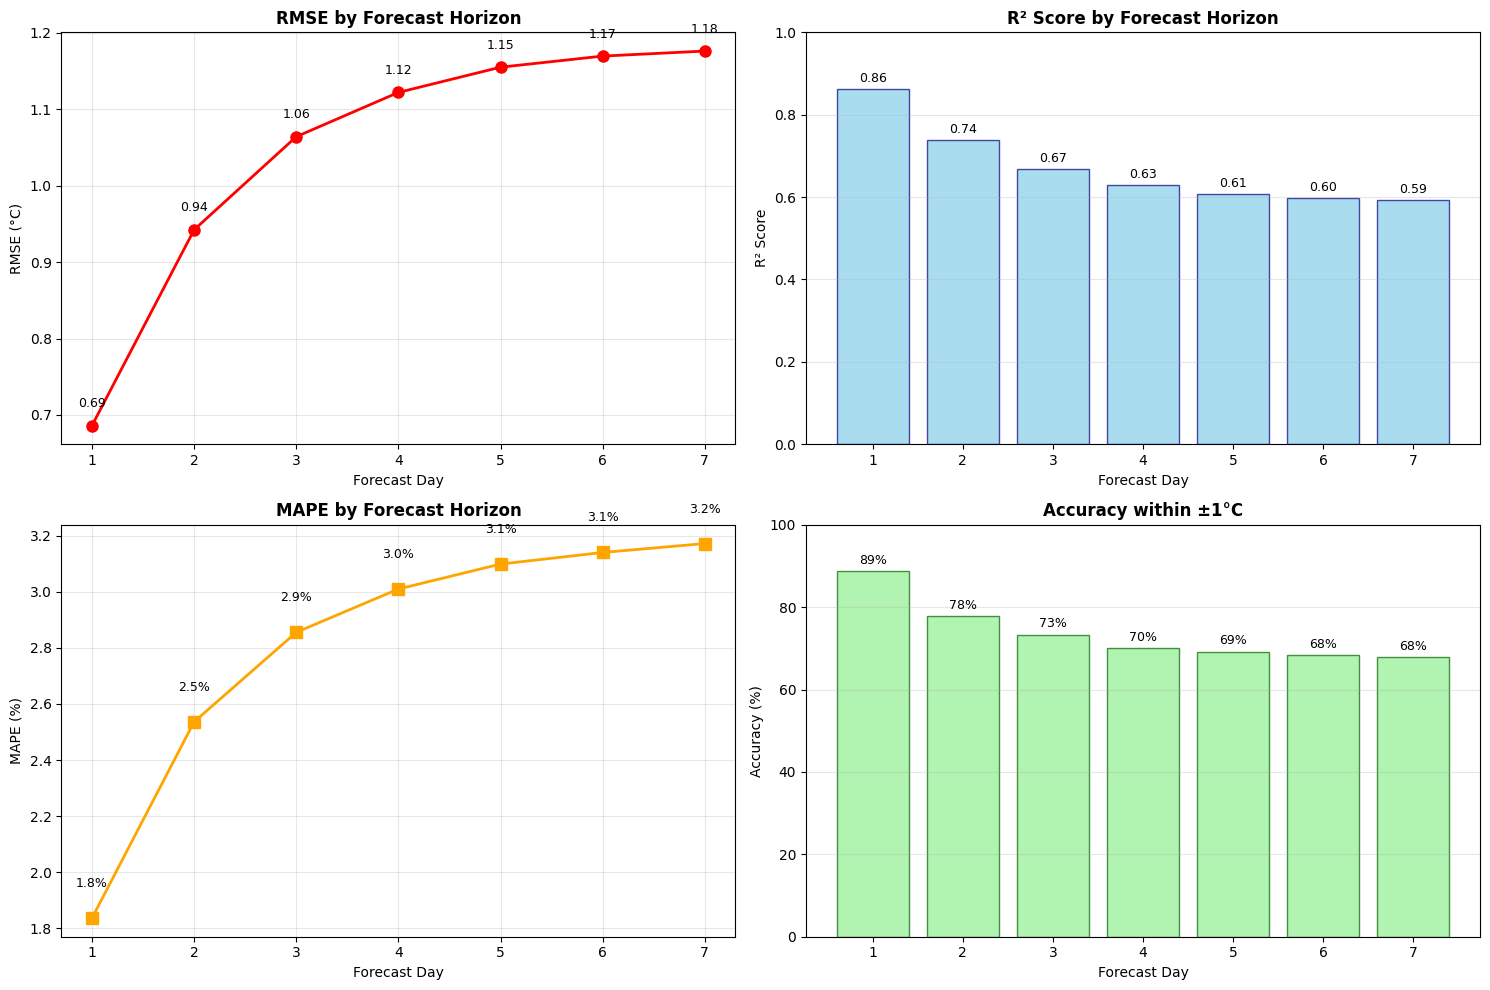

In [31]:
# Visual Performance Analysis
import matplotlib.pyplot as plt

# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. RMSE by forecast horizon
days = list(range(1, H+1))
rmse_by_day = [sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)]

axes[0, 0].plot(days, rmse_by_day, marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].set_title('RMSE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Forecast Day')
axes[0, 0].set_ylabel('RMSE (°C)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(days)

# 2. R² Score by forecast horizon
axes[0, 1].bar(days, r2_scores, color='skyblue', alpha=0.7, edgecolor='navy')
axes[0, 1].set_title('R² Score by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Forecast Day')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(days)
axes[0, 1].set_ylim(0, 1)

# 3. MAPE by forecast horizon
axes[1, 0].plot(days, mape_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_title('MAPE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Forecast Day')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(days)

# 4. Accuracy within 1°C tolerance
accuracy_1c = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    within_tolerance = np.abs(actual - predicted) <= 1.0
    accuracy = (within_tolerance.sum() / len(actual)) * 100
    accuracy_1c.append(accuracy)

axes[1, 1].bar(days, accuracy_1c, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
axes[1, 1].set_title('Accuracy within ±1°C', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Forecast Day')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(days)
axes[1, 1].set_ylim(0, 100)

# Add performance values as text on bars/points
for i, (day, rmse) in enumerate(zip(days, rmse_by_day)):
    axes[0, 0].text(day, rmse + 0.02, f'{rmse:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, r2) in enumerate(zip(days, r2_scores)):
    axes[0, 1].text(day, r2 + 0.01, f'{r2:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, mape) in enumerate(zip(days, mape_scores)):
    axes[1, 0].text(day, mape + 0.1, f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

for i, (day, acc) in enumerate(zip(days, accuracy_1c)):
    axes[1, 1].text(day, acc + 1, f'{acc:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Predict 7 days

In [32]:
X_last = df[selected_features].iloc[[-1]] # shape = (1, n_features)
t2m_next7 = model_xgb.predict(X_last)[0]

# Get the last date in dataset and generate next 7 days
last_date = pd.to_datetime(df["date"].iloc[-1])
print(f"Last data date: {last_date.strftime('%Y-%m-%d (%A)')}")
print(f"Starting forecast from: {(last_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d (%A)')}")
print()

# Generate forecast with dates
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]

for i, (date, temp) in enumerate(zip(forecast_dates, t2m_next7), start=1):
    day_name = date.strftime('%A')
    date_str = date.strftime('%Y-%m-%d')
    print(f"Day +{i}: {date_str} ({day_name}) → {temp:.2f}°C")

print(f"\nForecast Range: {t2m_next7.min():.2f}°C to {t2m_next7.max():.2f}°C")
print(f"Average Temperature: {t2m_next7.mean():.2f}°C")

# Temperature trend analysis
temp_trend = "increasing" if t2m_next7[-1] > t2m_next7[0] else "decreasing"
temp_change = abs(t2m_next7[-1] - t2m_next7[0])
print(f"7-day Trend: {temp_trend} ({temp_change:.2f}°C change)")

Last data date: 2025-11-10 (Monday)
Starting forecast from: 2025-11-11 (Tuesday)

Day +1: 2025-11-11 (Tuesday) → 27.53°C
Day +2: 2025-11-12 (Wednesday) → 27.18°C
Day +3: 2025-11-13 (Thursday) → 26.82°C
Day +4: 2025-11-14 (Friday) → 26.59°C
Day +5: 2025-11-15 (Saturday) → 26.45°C
Day +6: 2025-11-16 (Sunday) → 26.30°C
Day +7: 2025-11-17 (Monday) → 26.12°C

Forecast Range: 26.12°C to 27.53°C
Average Temperature: 26.71°C
7-day Trend: decreasing (1.41°C change)


### Pattern plot

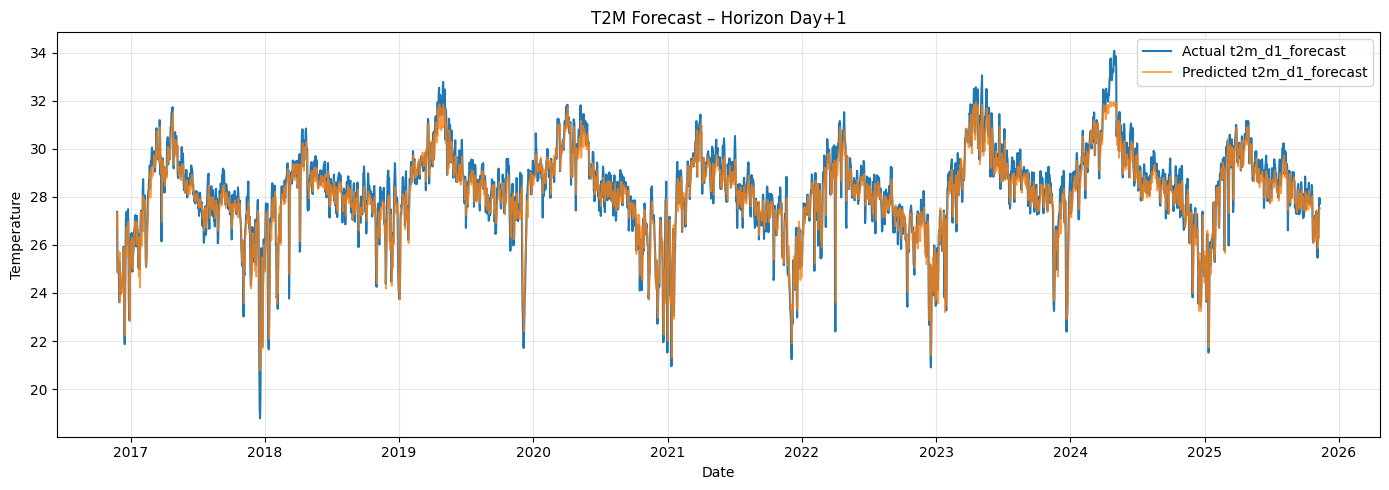

In [33]:
import matplotlib.pyplot as plt

# สร้าง date index สำหรับ test set
dates_test = pd.to_datetime(df["date"].iloc[split_idx:])

# เลือก horizon ที่อยากดู เช่น day+7 = index 6
h = 0   # 0 = day+1, 6 = day+7
target_name = t2m_targets[h]

plt.figure(figsize=(14, 5))
plt.plot(dates_test, Y_test.iloc[:, h], label=f"Actual {target_name}", linewidth=1.5)
plt.plot(dates_test, Y_pred[:, h], label=f"Predicted {target_name}", linewidth=1.2, alpha=0.8)

plt.title(f"T2M Forecast – Horizon Day+{h+1}")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

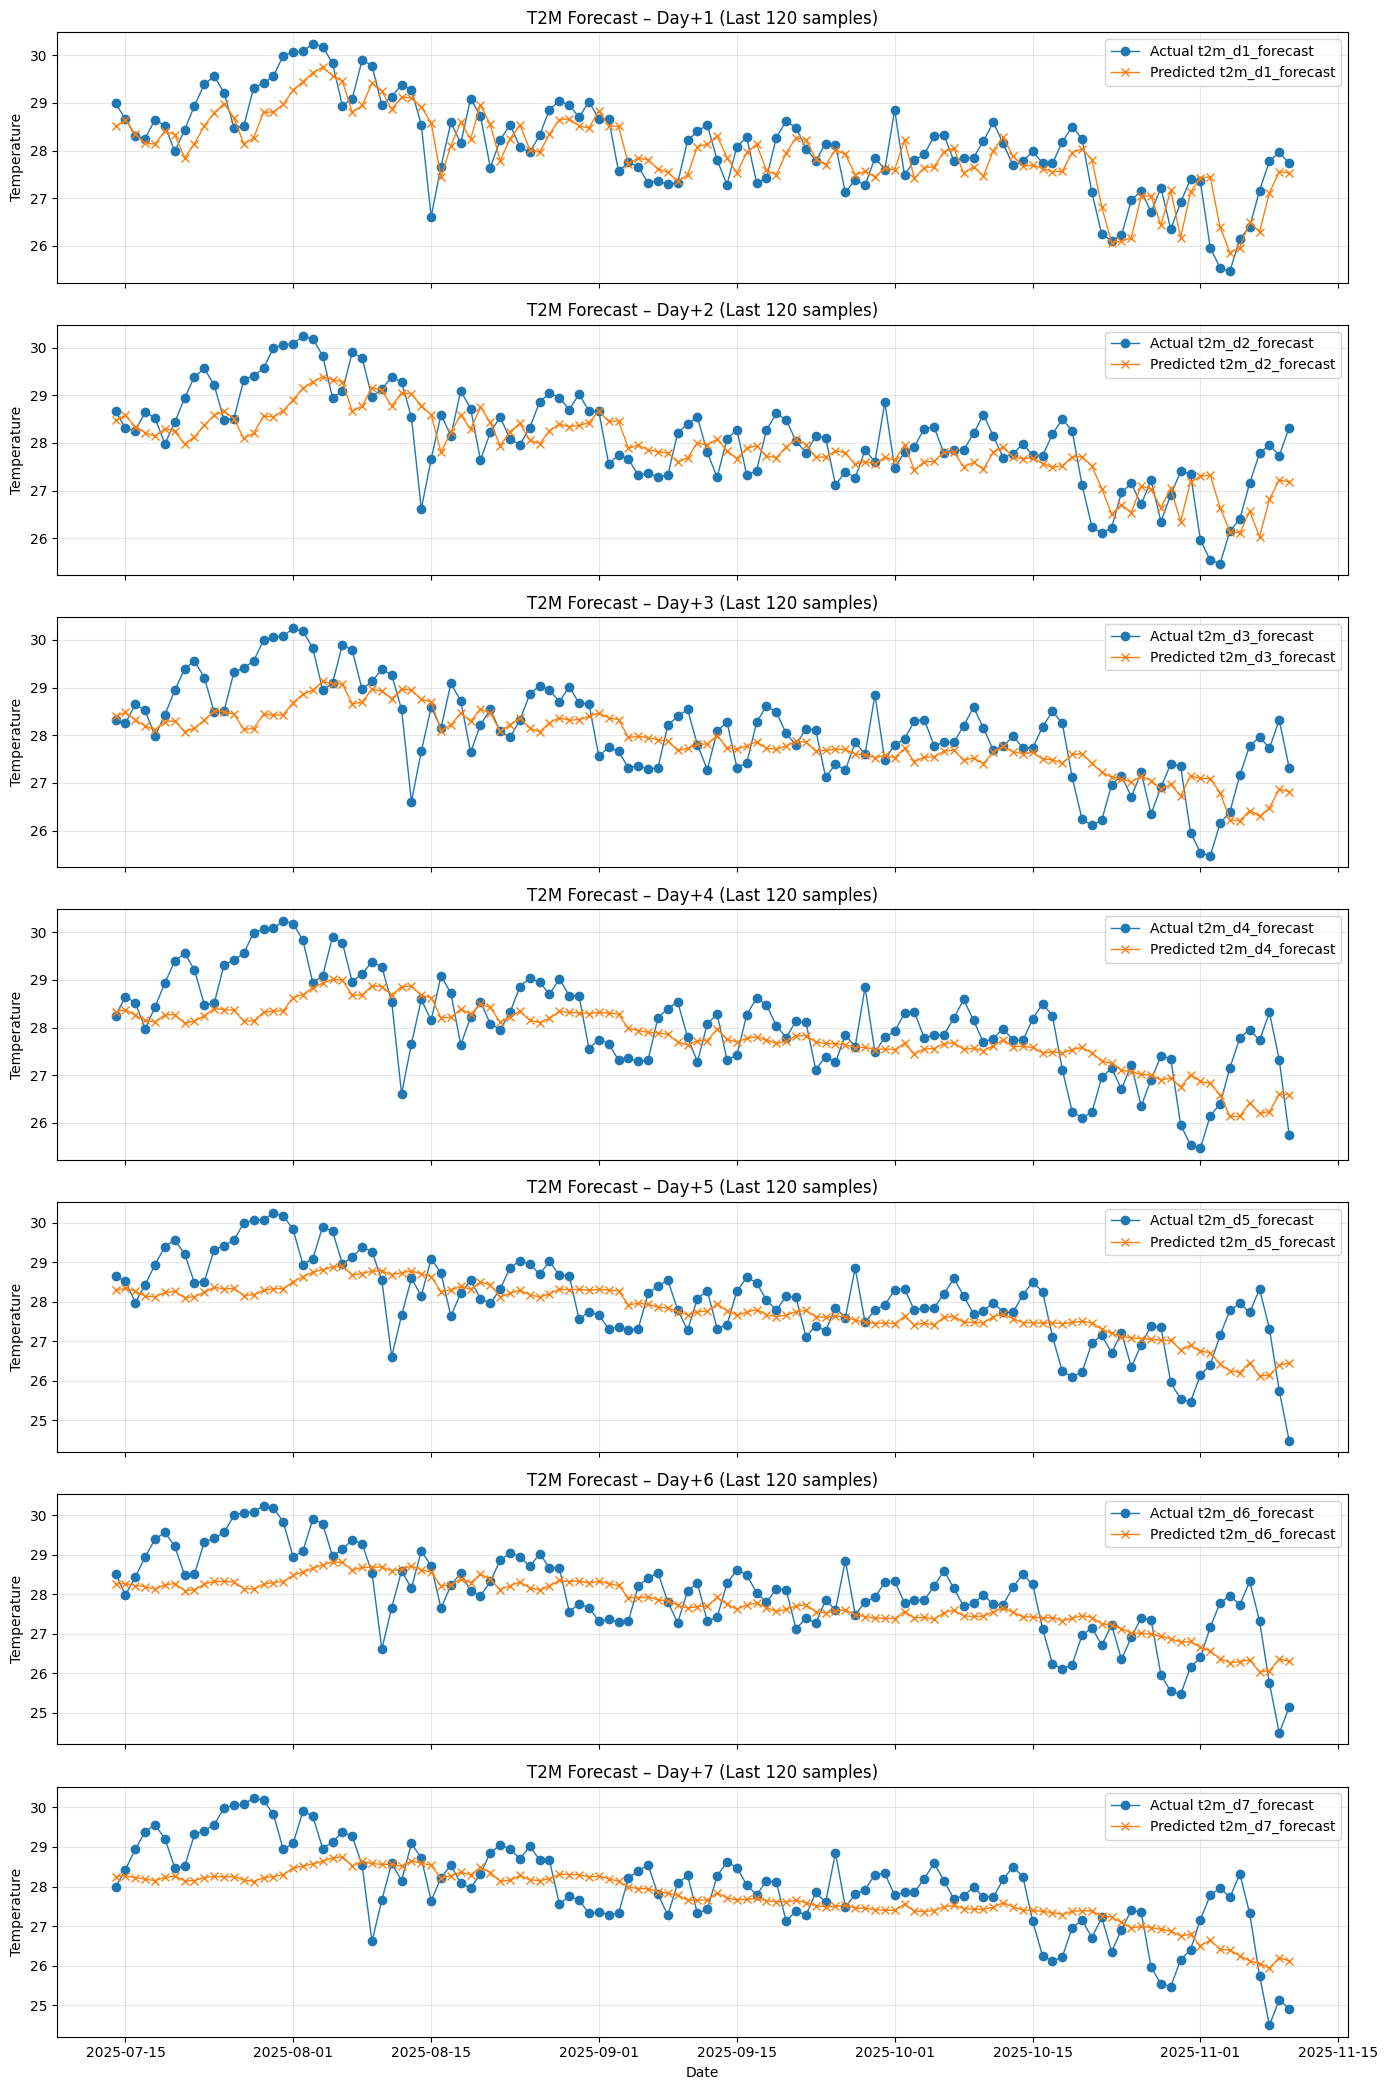

In [34]:
# จำนวนจุดที่อยาก zoom ดู
N = 120  # เช่น 4 เดือนสุดท้าย
days = [f"Day+{i+1}" for i in range(H)]
fig, axs = plt.subplots(H, 1, figsize=(14, 3*H), sharex=True)
for h in range(H):
    dates_zoom = dates_test[-N:]
    y_test_zoom = Y_test.iloc[-N:, h]
    y_pred_zoom = Y_pred[-N:, h]
    axs[h].plot(dates_zoom, y_test_zoom, label=f"Actual {t2m_targets[h]}", marker="o", linewidth=1)
    axs[h].plot(dates_zoom, y_pred_zoom, label=f"Predicted {t2m_targets[h]}", marker="x", linewidth=1)
    axs[h].set_title(f"T2M Forecast – {days[h]} (Last {N} samples)")
    axs[h].set_ylabel("Temperature")
    axs[h].legend()
    axs[h].grid(True, alpha=0.3)
plt.xlabel("Date")
plt.tight_layout()
plt.show()